In [ ]:
# not used poetry because i ran the code on google colab
%pip install transformers
%pip install datasets
%pip install bertviz
%pip install umap-learn

# Coding

In [ ]:
import pandas as pd
from datasets import list_datasets

c:\Users\arian\AppData\Local\pypoetry\Cache\virtualenvs\huggingface-models-13WJgs-Q-py3.11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
all_datasets = list_datasets()

C:\Users\arian\AppData\Local\Temp\ipykernel_27624\374882858.py:1: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()


In [ ]:
len(all_datasets)

87793

In [ ]:
# download emotion dataset
'dair-ai/emotion' in all_datasets

from datasets import load_dataset

emotion = load_dataset('emotion')
emotion.set_format(type='pandas')

In [ ]:
df = emotion['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [ ]:
classes = emotion['train'].features['label'].names
classes

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [ ]:
df['label_name'] = df['label'].apply(lambda x: classes[x])
#df.drop(columns=['emotion'], inplace=True)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


## Dataset Analysis

In [ ]:
%pip install matplotlib
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


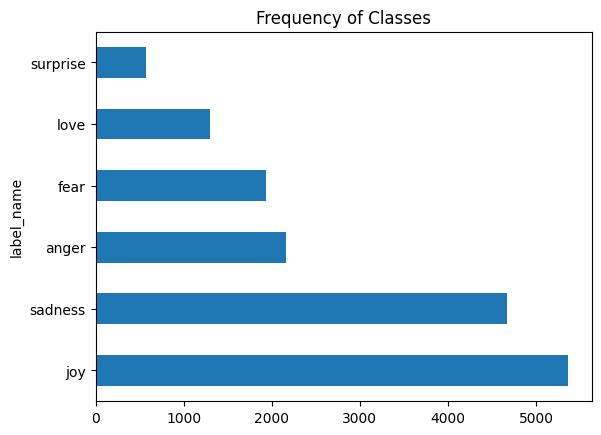

In [ ]:
# the count of each label
label_counts = df['label_name'].value_counts() 
label_counts.plot.barh()
plt.title('Frequency of Classes')

plt.show()

<Axes: title={'center': 'words per tweet'}, xlabel='label_name'>

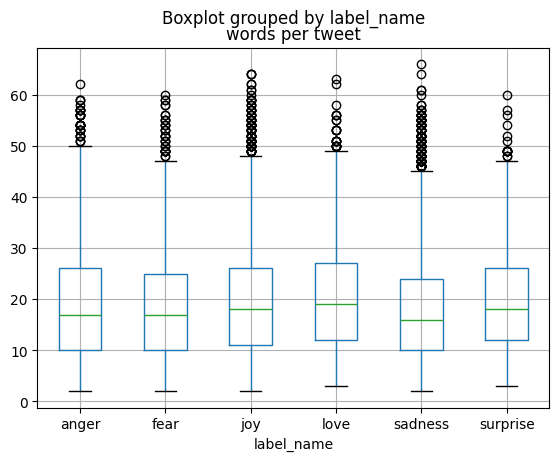

In [ ]:
df['words per tweet'] = df['text'].str.split().apply(len)
df['words per tweet']

df.boxplot('words per tweet', by='label_name')

## Text to Tokens Conversion 

- Transformer models like DistilBERT cannot receive raw strings as input. Instead, they assume the text has been tokenized and encoded as numerical vectors.

In [ ]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
text = "I am happy because tokenization is awesome!"
encoded_text = tokenizer(text)
encoded_text

{'input_ids': [101, 1045, 2572, 3407, 2138, 19204, 3989, 2003, 12476, 999, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text['input_ids'])
tokens

['[CLS]',
 'i',
 'am',
 'happy',
 'because',
 'token',
 '##ization',
 'is',
 'awesome',
 '!',
 '[SEP]']

In [ ]:
# DistilBERT model was trained on bookcorpus and wikipedia
tokenizer.vocab_size, tokenizer.model_max_length

(30522, 512)

## Tokenization of the Emotion Data

In [ ]:
emotion.reset_format() #emotion not in pandas format anymore

In [ ]:
# map
def tokenize(batch):
    temp = tokenizer(batch['text'], padding = True, truncation = True)
    return temp
tokenize(emotion['train'][:2])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [ ]:
emotions_encoded = emotion.map(tokenize, batched = True, batch_size = None)

Map: 100%|██████████| 2000/2000 [00:00<00:00, 10865.21 examples/s]


In [ ]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

## Model Building 

In [ ]:
text

'I am happy because tokenization is awesome!'

In [ ]:
inputs = tokenizer(text, return_tensors = 'pt') # return as pytorch tensors
inputs

{'input_ids': tensor([[  101,  1045,  2572,  3407,  2138, 19204,  3989,  2003, 12476,   999,
           102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
from transformers import AutoModel 
import torch

model = AutoModel.from_pretrained(model_ckpt)

In [ ]:
model

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [ ]:
# generate embedding to the model   
with torch.no_grad():
    outputs = model(**inputs) # model output with all layers

last_hidden_state = outputs.last_hidden_state # last hidden state

In [ ]:
last_hidden_state.shape

torch.Size([1, 11, 768])

# Fine-Tuning Transformers

- AutoModelForSequenceClassification model has a classification head on top of the pretrained model outputs


In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = len(classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # use gpu if available
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels = num_labels).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device

device(type='cpu')

In [3]:
from transformers import TrainingArguments

In [4]:

batch_size = 64
model_name = "distilbert-finetuned-emotion"

training_args = TrainingArguments(output_dir=model_name, 
                                  num_train_epochs = 2,
                                  learning_rate = 2e-5,
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size = batch_size,
                                  weight_decay = 0.01,
                                  evaluation_strategy = "epoch",
                                  accelerate = True,
                                  disable_tqdm = False)

In [5]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average = 'weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1}

In [ ]:
from transformers import Trainer

trainer = Trainer(model = model, args = training_args, 
                  compute_metrics = compute_metrics,
                  train_dataset = emotions_encoded['train'],
                  eval_dataset = emotions_encoded['validation'],
                  tokenizer = tokenizer)

In [ ]:
trainer.train()  

In [ ]:
preds_output = trainer.predict(emotions_encoded['test'])
preds_output.metrics

In [ ]:
import numpy as np 
y_preds = np.argmax(preds_output.predictions, axis = 1)
y_true = emotions_encoded['test'][:]['label']

In [ ]:
from sklearn.metrics import classification_report
print(classes)
print(classification_report(y_true, y_preds))

In [ ]:
label_counts

In [ ]:
text = "I am happy because tokenization is awesome!"
input_encoded = tokenizer(text, return_tensors = 'pt').to(device)
with torch.no_grad():
    output = model(**input_encoded)  
logits = output.logits
pred = torch.argmax(logits, dim = 1).item()
pred, classes[pred]

In [ ]:
output